<a href="https://colab.research.google.com/github/mjgroth/deephys-aio/blob/master/tutorials/CIFAR_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 1. Install dependencies

!pip install torch torchvision # We will use Torch as the deep net platform
!pip install deephys --upgrade # To export the neural activity to deephys

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title 2. Define neural net model

#Import Libraries
from __future__ import print_function
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np


# Neural network model definition (Different ResNet versions)
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear1 = nn.Linear(512*block.expansion, 50)
        self.linear2 = nn.Linear(50, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.linear2(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [3]:
#@title 3. Load the model. Define hooks to extract the neural activity from the network

args={}
args['batch_size'] = 128
args['cuda'] = True # Enabling cuda is required

# Instntiate model
model = ResNet18()
if args['cuda']:
    model.cuda()

#Load pre-trained model
state_dict = torch.load('cifar_resnet18.pth')
model.load_state_dict(state_dict)
model.eval() # testing model

# Hooks to extract the neural activity from the model
model_activity = {}
def get_activation(name):
  def hook(model, input, output):
    model_activity[name] = output.detach()
  return hook

# We will only pull from the linear1 layer
h = model.linear1.register_forward_hook(get_activation('linear1'))

In [4]:
#@title 4. Define function to extract data to export to deephys from the model

def extract_activity(testloader, model):

  # All we need for Deephys
  dp_images = []
  dp_gt = []
  dp_activity = {
      "output": [], 
      "linear1": []
  }

  #Standard normalization for CIFAR10 versions
  normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  
  # Loop across all dataset 
  for data, target in iter(testloader):

      dp_images.append(data)
      dp_gt.append(target)

      if args['cuda']:
        data, target = data.cuda(), target.cuda()

      data = normalize(data) #Required to capture activations with normalized data
  
      with torch.no_grad():
        tmp_activity = model(data).detach().cpu()
        dp_activity['output'].append(tmp_activity)
        tmp_activity = F.relu(model_activity['linear1']).detach().cpu()
        dp_activity['linear1'].append(tmp_activity)

  # Convert torch tensors to numpy
  for layer in dp_activity:
        dp_activity[layer] = torch.cat(dp_activity[layer]).numpy()

  dp_images = torch.cat(dp_images).numpy()
  dp_gt = torch.cat(dp_gt).numpy()

  return dp_images, dp_gt, dp_activity

In [5]:
#@title 5. Deephys model

import deephys as dp

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

dp_model = dp.model(
    name = "resnet18_cifar",
    layers = {
        "linear1": model.linear1.out_features,
        "output": len(classes)
    },
    classification_layer="output"
)

dp_model.save()

Saving data to resnet18_cifar.model...
done saving data to resnet18_cifar.model


In [6]:
#@title 6. Export data from CIFAR to Deephys

# CIFAR
transform_test = transforms.Compose([transforms.ToTensor(),])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=args['batch_size'],
                                         shuffle=False, num_workers=2)

cifar_images, cifar_gt, cifar_activity = extract_activity(testloader, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "CIFAR10",
    category_names = classes,
    images = cifar_images,
    groundtruth = cifar_gt,
    neural_activity = cifar_activity,
    model=dp_model,
    )
dataset_activity.save()

Files already downloaded and verified
Preparing data...


100%|██████████| 10000/10000 [00:02<00:00, 3476.11it/s]


Saving data to CIFAR10.test...
done saving data to CIFAR10.test


In [7]:
#@title 7. Export data from CIFAR2 to Deephys

# CIFAR 2
testset2 = np.load('cifar102_train.npz')
images2 = np.transpose(testset2['images'], (0, 3, 1, 2))/255. #Required before the images can be fed to the model
tensor_testset2 = TensorDataset(torch.FloatTensor(images2), torch.LongTensor(testset2['labels']))
testloader2 = torch.utils.data.DataLoader(tensor_testset2,
    batch_size=args['batch_size'], shuffle=False)

cifar2_images, cifar2_gt, cifar2_activity = extract_activity(testloader2, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "CIFAR10.2",
    category_names = classes,
    images = cifar2_images,
    groundtruth = cifar2_gt,
    neural_activity = cifar2_activity,
    model=dp_model,
    )
dataset_activity.save()

Preparing data...


100%|██████████| 10000/10000 [00:03<00:00, 2731.41it/s]


Saving data to CIFAR10.2.test...
done saving data to CIFAR10.2.test


# Novelty and Spurious Scores



In [8]:
#@title Normalize and get average firing rates per category

num_neurons = model.linear1.out_features
num_classes = len(classes)

# Normalize each neuron with the maximum firign rate
norm = np.max(cifar_activity["linear1"], axis=0)
cifar_activity["linear1"] /= norm
cifar2_activity["linear1"] /= norm


# Average scores for every concept across all images
Y = np.array([np.mean(cifar_activity["linear1"][np.where(cifar_gt == c)[0], :], axis=0) 
          for c in range(num_classes)]) #CIFAR

Y2 = np.array([np.mean(cifar2_activity["linear1"][np.where(cifar2_gt == c)[0], :], axis=0) 
          for c in range(num_classes)]) #CIFAR 2

In [9]:
#@title Calculate Spurious and Novelty scores

from scipy.stats.mstats import spearmanr
import pandas as pd

def Spurious_Score(avg_acts_1, avg_acts_2):
    #Spearman's rank correlation calculation
    spearman_corr = [1-abs(spearmanr(avg_acts_1[i], avg_acts_2[i])[0])
          for i in range(len(avg_acts_1))]
    
    return spearman_corr

def Novelty_Score(avg_acts_1, avg_acts_2):
  max_c = np.max(avg_acts_1, axis=1)
  max_c_per = np.max(avg_acts_2, axis=1)

  dis_c_per = list(max_c - max_c_per)
  return dis_c_per


# Calculate and store in dataframe
spurious = Spurious_Score(Y, Y2)
novelty = Novelty_Score(Y, Y2)

df = pd.DataFrame({
  'Spurious': spurious,
  'Novelty': novelty
})

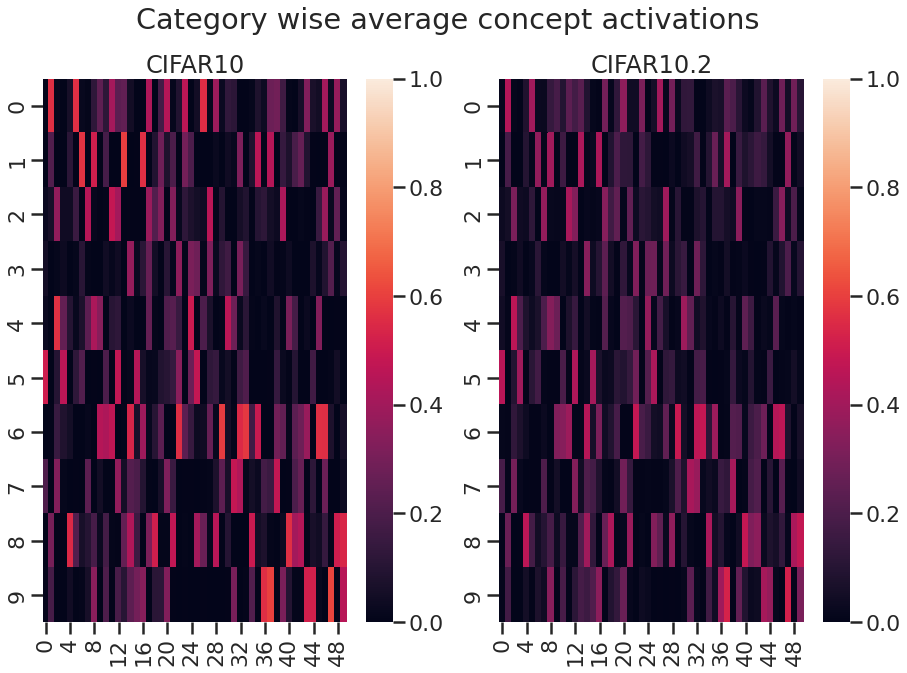

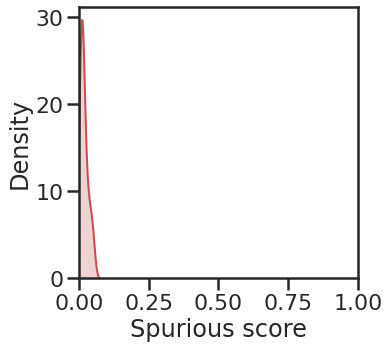

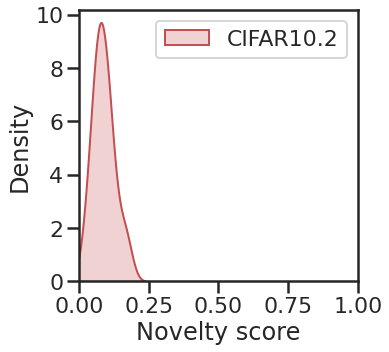

In [10]:
#@title Plot scores

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set_context("poster")


fig, axes = plt.subplots(1, 2, figsize = (15, 10))
fig.suptitle('Category wise average concept activations')
fig = sns.heatmap(Y, ax=axes[0], vmin=0, vmax=1)
fig = sns.heatmap(Y2, ax=axes[1], vmin=0, vmax=1)

axes[0].set_title('CIFAR10')
axes[1].set_title('CIFAR10.2')


fig, axes = plt.subplots(1, 1, figsize = (5, 5))
fig = sns.kdeplot(df['Spurious'], shade=True, color="r")
plt.xlim(0, 1)
axes.set_xlabel('Spurious score')

plt.show()
g = fig.figure
g.savefig("CIFAR_spurious.pdf", bbox_inches='tight')

fig, axes = plt.subplots(1, 1, figsize = (5, 5))
fig = sns.kdeplot(df['Novelty'], shade=True, color="r")
plt.xlim(0, 1)
plt.gca().legend(('CIFAR10.2',), loc ="upper right")
axes.set_xlabel('Novelty score')

plt.show()
g = fig.figure
g.savefig("CIFAR_novelty.pdf", bbox_inches='tight')